In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


> # **MNIST Neural Network from Scratch w/ mult layers**

Objetivo: Estudar o projeto criado de redes neurais somente com pandas e numpy para análise do dataset MNIST, melhorando o modelo com a adição de mais layers.

DIAGRAMA DO PROJETO: https://app.diagrams.net/#G1aNEniOxCATXECjdoEAyPIMMM3V8dTtxh

Estudo utilizando versão fonte: https://www.youtube.com/watch?v=w8yWXqWQYmU

Baseado no modelo de Samson Zhang: https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook

> **TRAZENDO OS DADOS DO DIGIT-RECOGNIZER**

1. Importando os dados de treino

In [2]:
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
sample = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

print(data.head())
print(test.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

'label' corresponde ao digito (0 - 9)

'pixel' corresponde a escala em cinza (gray-scale) para cada pixel (0 - 784) onde referencia a imagem de 28w x 28h = 784

> # **INICIANDO A CRIAÇÃO DO MODELO MODELO**

> ### Preparando os dados

1. Transformando o dataset em um array com numpy

2. Dimensão dos dados

3. Para garantir que não ocorra **overfitting** baseado na distribuição dos dados, é utilizado a função random.shuffle() para reduzir o risco.

In [3]:
data = np.array(data)   # 1. Transforma o dataset em array
m, n = data.shape       # 2. Dimensão dos dados (rows e features + 1(label))
np.random.shuffle(data) # 3. Elimina o risco de overfitting
print("Dados: ", data)
print("Rows: ", m)
print("Features + Label: ", n)

test = np.array(test)   # 1. Transforma o dataset em array
tm, tn = test.shape       # 2. Dimensão dos dados (rows e features + 1(label))
print("Dados: ", data)
print("Rows: ", tm)
print("Features + Label: ", tn)

Dados:  [[1 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [8 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]]
Rows:  42000
Features + Label:  785
Dados:  [[1 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [8 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]]
Rows:  28000
Features + Label:  784


In [4]:
data_dev = data[0:1000].T #Transpõe a matriz
Y_dev = data_dev[0]       #Label -> primeira linha
X_dev = data_dev[1:n]     #Features -> 784
X_dev = X_dev / 255.

data_train = data[1000:m].T #Transpõe a matriz
Y_train = data_train[0]     #Label -> primeira linha
X_train = data_train[1:n]   #Features -> 784
X_train = X_train / 255.
_,m_train = X_train.shape


data_test = test[0:tm].T #Transpõe a matriz
X_test = data_test[0:tn]   #Features -> 784
X_test = X_test / 255.
_,m_test = X_test.shape

> # INICIANDO MODELO DE PROPAGAÇÃO

> ### Funções iniciais e de ativação

1. init_params() -> Cria dados em formato de uma distribuição normal uniforme entre -0,5 e 0,5 para os parametros de W = Weights e b = Bias para os Nodes ( 1 e 2 )

2. ReLU(Z) -> Função de ativação que transforma Z no método ReLU (if x>0 them x else 0)

3. Softmax(Z) -> Função de ativação no método softmax

4. one_hot(Y) -> Transforma os valores de um array Y em uma matriz para 0 ou 1 (one-hot-econding) para cada valor.

In [5]:
# A função np.random.rand retorna valores entre -1 e 1, 
# então adicionamos o -0,5 para retornar valores entre -0,5 e 0,5
def init_params(): 
    W1 = np.random.rand(200, 784) - 0.5 
    b1 = np.random.rand(200, 1) - 0.5
    W2 = np.random.rand(10, 200) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0) # Para cada valor de Z, se for maior que 0 retorna Z, se não, retorna 0.

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z)) # Função exponencial, então temos e^Z / sum(e^Z)
    return A

def ReLU_deriv(Z): # Se ReLU é linear, sua derivada é 0 então:
    return Z > 0 # true = 1 false = 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

> ### Foward Propagation

OBS: Baseado no diagrama do método de propagação, X = A0 -> input layer
     .dot() = Dot Product, referente ao produto escalar de matrizes

In [6]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1 # Produto escalar W1 e X(input layer)
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

> ### Backward Propagation

In [7]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

> ### Update Parametros

Encontra o melhor estimador para Weights e Bias

In [8]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

> ### Funções para treinar o modelo

1. get_predictions(A2) -> retorna o maior valor do indice de um np.array

2. get_accuracy(predictions, Y) -> soma(np.argmax(A2, 0) == Y) / Y.size

3. gradient_descent(X, Y, alpha, iterations) -> treina o modelo com dados de treino, alpha = learning rate e iterations é o numero de ciclos de aprendizagem do modelo

In [9]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params() # Cria parametros de Weight e Bias
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0: # Para cada 10 iterations, print
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

> #### Executando o modelo

In [10]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 10)

Iteration:  0
[9 0 9 ... 9 9 9] [8 0 2 ... 8 8 8]
0.1054390243902439


> ### Funções para executar o modelo

In [11]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

> ### Predição com o modelo

Prediction:  [2]
Label:  8


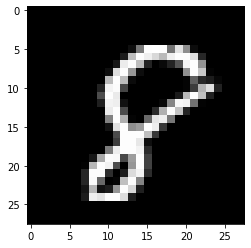

In [12]:
indexrand = np.random.randint(1,tm)
test_prediction(indexrand, W1, b1, W2, b2)

In [13]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[1 2 0 7 1 1 1 7 1 1 9 8 0 4 7 8 1 8 8 7 7 4 9 9 8 4 8 8 9 3 4 1 2 1 5 3 3
 9 1 0 9 0 0 2 7 1 7 3 9 1 2 9 0 7 8 5 0 5 8 6 2 0 2 8 7 4 6 6 8 4 8 4 3 1
 2 9 3 8 1 8 7 8 3 0 7 6 9 9 3 8 5 7 5 1 8 7 6 6 9 4 6 9 3 5 9 8 1 1 0 4 0
 1 6 1 6 4 6 8 9 0 1 0 2 7 1 2 3 0 1 3 9 5 0 3 6 0 2 3 8 2 0 5 9 2 6 0 1 3
 4 7 6 5 2 6 6 0 6 8 0 7 3 9 2 7 3 2 9 8 3 8 3 0 6 3 3 3 1 1 4 8 1 6 9 1 7
 2 0 0 9 7 7 0 6 4 8 3 1 7 8 5 5 0 5 0 7 6 0 7 2 8 9 4 1 6 2 9 1 8 3 3 7 8
 6 8 3 3 9 7 3 0 6 8 2 6 0 9 6 7 1 6 0 6 2 7 3 6 2 8 9 4 3 0 7 0 1 9 1 4 7
 7 5 1 6 7 3 4 1 4 2 0 8 0 6 2 5 4 1 2 5 9 8 4 5 7 6 5 3 4 1 7 2 6 1 9 9 8
 1 1 7 6 4 5 6 9 0 6 7 1 8 9 2 7 0 3 4 2 9 2 4 0 0 7 5 0 1 3 2 1 8 7 3 6 0
 9 3 3 7 7 8 4 8 2 5 5 3 7 7 6 1 6 9 2 0 1 4 9 4 2 7 9 8 9 2 0 4 4 8 0 9 6
 0 9 8 3 1 8 5 2 3 8 4 9 6 6 9 6 2 1 5 0 6 3 8 4 9 2 3 4 4 6 9 0 1 6 6 5 7
 2 9 9 9 6 5 2 3 3 1 3 7 3 0 2 3 2 5 3 8 4 4 8 5 2 0 8 1 2 1 8 0 1 2 8 2 8
 2 9 5 6 8 3 1 4 6 3 0 0 2 7 3 2 2 1 7 2 8 1 1 6 7 7 6 0 1 3 7 8 8 1 5 1 7
 5 4 5 3 8 8 6 6 2 8 2 3 

0.516

> ### Dados de test.csv

Testando a acurácia do modelo com os dados de test.csv

In [14]:
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
j = test_predictions.shape

print("Predictions: ",test_predictions, "rows: ", j[0])
#get_accuracy(dev_predictions, Y_test)

Predictions:  [2 5 9 ... 3 9 5] rows:  28000


In [15]:
submissions = pd.DataFrame({"ImageId": list(range(1,len(test_predictions)+1)),
    "Label": test_predictions})
submissions.to_csv("submissions.csv", index=False, header=True)

# TENTANDO CRIAR UM ALGORITMO DE DEEP LEANING

In [16]:
# classe de redes neurais

# NN pelo método de propagação com treino baseado em gradient descent
class neural_network:
    
    def __init__(nodes, X):
        #Numero de Features para automatizar input layers
        X = np.array(X)
        m, n = X.shape
        
        #Criando W e b baseado na quantidade de nodes e layers
        W1 = np.random.rand(nodes, m) - 0.5 
        b1 = np.random.rand(nodes, 1) - 0.5
        W2 = np.random.rand(10, nodes) - 0.5
        b2 = np.random.rand(10, 1) - 0.5
        return W1, b1, W2, b2
    
    def ReLU(Z):
        # Para cada valor de Z, se for maior que 0 retorna Z, se não, retorna 0.
        return np.maximum(Z, 0) 

    def softmax(Z):
        # Função exponencial, então temos e^Z / sum(e^Z)
        A = np.exp(Z) / sum(np.exp(Z)) 
        return A

    # Se ReLU é linear, sua derivada é 0 então:
    def ReLU_deriv(Z): 
        # true = 1 false = 0
        return Z > 0 

    def one_hot(Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    def forward_prop(W1, b1, W2, b2, X):
        Z1 = W1.dot(X) + b1 # Produto escalar W1 e X(input layer)
        A1 = neural_network.ReLU(Z1)
        Z2 = W2.dot(A1) + b2
        A2 = neural_network.softmax(Z2)
        return Z1, A1, Z2, A2

    def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
        one_hot_Y = neural_network.one_hot(Y)
        dZ2 = A2 - one_hot_Y
        dW2 = 1 / m * dZ2.dot(A1.T)
        db2 = 1 / m * np.sum(dZ2)
        dZ1 = W2.T.dot(dZ2) * neural_network.ReLU_deriv(Z1)
        dW1 = 1 / m * dZ1.dot(X.T)
        db1 = 1 / m * np.sum(dZ1)
        return dW1, db1, dW2, db2

    def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
        W1 = W1 - alpha * dW1
        b1 = b1 - alpha * db1    
        W2 = W2 - alpha * dW2  
        b2 = b2 - alpha * db2    
        return W1, b1, W2, b2
    
    def get_predictions(A2):
        return np.argmax(A2, 0)
    
    def predict(X, model):
        _, _, _, A2 = neural_network.forward_prop(model[0], model[1], model[2], model[3], X)
        predictions = neural_network.get_predictions(A2)
        return predictions
    
    def get_accuracy(predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    # Treino de modelo com Cost Function (1 - acuracia) do modelo e dos dados de teste
    def train_wcost(X, Y, X_test, Y_test, alpha, iterations, nodes):
        
        cost_train = []
        cost_test = []
        epoch = []
        
        W1, b1, W2, b2 = neural_network.__init__(nodes ,X) # Cria parametros de Weight e Bias
        
        for i in range(iterations):
            Z1, A1, Z2, A2 = neural_network.forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = neural_network.backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = neural_network.update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
            
            predictions = neural_network.get_predictions(A2)
            accuracy = neural_network.get_accuracy(predictions, Y)
            
            _, _, _, A2_test = neural_network.forward_prop(W1, b1, W2, b2, X_test)
            predictions_test = neural_network.get_predictions(A2_test)
            accuracy_test = neural_network.get_accuracy(predictions_test, Y_test)
            
            
            
            cost_train.append(1 - accuracy)
            cost_test.append(1 - accuracy_test)
            epoch.append(i)
            
            if i % 10 == 0: # Para cada 10 iterations, print
                print("Iteration: ", i)
                print("Train: ", 1 - accuracy)
                print("Test: ", 1 - accuracy_test)

        plt.plot(epoch, cost_train)
        plt.plot(epoch, cost_test)
        
        return W1, b1, W2, b2, np.array(cost_train), np.array(cost_test), np.array(epoch), plt.show()
    
    def train(X, Y, alpha, iterations, nodes, learning_curve):
            
        cost = []
        epoch = []
        
        W1, b1, W2, b2 = neural_network.__init__(nodes ,X) # Cria parametros de Weight e Bias
        for i in range(1, iterations+1):
            Z1, A1, Z2, A2 = neural_network.forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = neural_network.backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = neural_network.update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
            
            predictions = neural_network.get_predictions(A2)
            accuracy = neural_network.get_accuracy(predictions, Y)
            
            if i % 1 == 0: # Para cada 10 iterations, print
                print("Iteration: ", i)
                print(accuracy)
                
        return W1, b1, W2, b2

In [17]:
model = neural_network.train(X_train, Y_train, 0.15, 20, 10, False)
predicao = neural_network.predict(X_train, model)
neural_network.get_accuracy(predicao, Y_train)

Iteration:  1
0.09065853658536585
Iteration:  2
0.0913170731707317
Iteration:  3
0.09775609756097561
Iteration:  4
0.10995121951219512
Iteration:  5
0.12270731707317073
Iteration:  6
0.1373658536585366
Iteration:  7
0.15141463414634146
Iteration:  8
0.16465853658536586
Iteration:  9
0.17802439024390243
Iteration:  10
0.18997560975609756
Iteration:  11
0.2005609756097561
Iteration:  12
0.21092682926829268
Iteration:  13
0.2205609756097561
Iteration:  14
0.2302439024390244
Iteration:  15
0.23829268292682926
Iteration:  16
0.24592682926829268
Iteration:  17
0.2539268292682927
Iteration:  18
0.26290243902439026
Iteration:  19
0.2701707317073171
Iteration:  20
0.27775609756097563


0.28448780487804876

Iteration:  0
Train:  0.930390243902439
Test:  0.927
Iteration:  10
Train:  0.8274634146341464
Test:  0.841
Iteration:  20
Train:  0.781609756097561
Test:  0.789
Iteration:  30
Train:  0.7311463414634146
Test:  0.728
Iteration:  40
Train:  0.6467317073170732
Test:  0.64
Iteration:  50
Train:  0.573609756097561
Test:  0.5740000000000001
Iteration:  60
Train:  0.5195853658536586
Test:  0.524
Iteration:  70
Train:  0.47397560975609754
Test:  0.482
Iteration:  80
Train:  0.43380487804878054
Test:  0.43000000000000005
Iteration:  90
Train:  0.3984878048780488
Test:  0.39


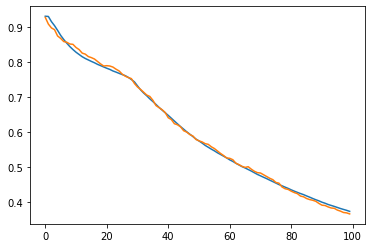

In [18]:
learningcurve = neural_network.train_wcost(X_train, Y_train, X_dev, Y_dev,0.1, 100, 10)